In [1]:
import sys
import numpy as np
import pandas as pd 
import tensorflow_probability as tfp
import tensorflow.compat.v2 as tf
import matplotlib.pyplot as plt 
%matplotlib inline
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
sys.path.append("/home/mindy/Documents/projects/creditCardFraud/scripts/")

In [2]:
tfk = tf.keras
tfkl=tf.keras.layers
tfpl= tfp.layers         # layers for tensor flow probability 
tfd = tfp.distributions # distribution layer 

In [3]:
from util import *
%load_ext autoreload
%autoreload 2

In [4]:
# make sure GPU is running 
tf.test.gpu_device_name()

'/device:GPU:0'

In [5]:
gpus = tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_virtual_device_configuration(gpus[0],
[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*7)])  # limit to 7 G

## Import training and dev data and convert to numpy array for NN 

In [6]:
train = pd.read_csv("../processedData/TrainingData_normal.csv").values
dev = pd.read_csv("../processedData/DevData_normal.csv").values

### converting into tf data set to allow simple efficient data pipelines. 
* In autoencoder, you are predicting the original input x 
* shuffle and train data in batches with 1000 epochs 

In [7]:
buffer_size = 10000
batch_size = 256
epochs = 500
input_size = train.shape[1]
encoded_size = 5

In [8]:
train = tf.data.Dataset.from_tensor_slices((train,train)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE).shuffle(buffer_size)
dev = tf.data.Dataset.from_tensor_slices((dev,dev)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE).shuffle(buffer_size)

### set up checkpoint and other settings 

In [9]:
checkpoint = tfk.callbacks.ModelCheckpoint("../savedModels/VariationalEncoderModel_2.h5",verbose=1,save_best_only=True)
earlystop = tfk.callbacks.EarlyStopping(monitor="val_loss", mode="min", min_delta=0.005, patience=20, verbose=1, restore_best_weights=True)

### For variational autoencoder we need to maximize ELBO (evidence lower bound objective):

$$ELBO(x)= \int dzq(z|x)logp(x|z) + \int dzq(z|x)log\frac{q(z|x)}{p(z)} $$

* p(z): the prior on the latent representation z (last layer of encoder) 
* q(z|x_input): the encoder (how likely is z given x_input)
* p(x_hat|z): the decoder (how likely is x_hat given z) 
* $\int dzq(z|x)logp(x|z)$: reconstructin term. (how likely for us to get output_x given input_x and encode to z then decode to x_output) 
* $\int dzq(z|x)log\frac{q(z|x)}{p(z)} $: KL divergence. How similar are the encoder distribution and the prior distribution. 

### Prior distribution for z: 

* Since this is latent representation (noise has been removed), it is okay to assume it is isotropic gaussian 

In [10]:
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(encoded_size), scale=1),
                        reinterpreted_batch_ndims=1)

## encoder model for autoencoder:
* encoder: 3 layers:
  * 3 dense layers 
  * 3 dimensional multivariable non zero covariance normal distribution

In [11]:
encoder = tfk.Sequential([
    tfkl.InputLayer(input_shape = input_size),  # 30 input features 
    tfkl.Dense(units=20, activation=tf.nn.leaky_relu, activity_regularizer=tfk.regularizers.l1(10e-5)),
    tfkl.Dense(units=10, activation=tf.nn.leaky_relu, activity_regularizer=tfk.regularizers.l1(10e-5)),
    tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(encoded_size),activation=None),
    tfpl.MultivariateNormalTriL(encoded_size,activity_regularizer=tfpl.KLDivergenceRegularizer(prior))
    ], name="encoder")
encoder.summary()    

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                620       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                220       
_________________________________________________________________
multivariate_normal_tri_l (M ((None, 5), (None, 5))    0         
Total params: 1,050
Trainable params: 1,050
Non-trainable params: 0
_________________________________________________________________


## decoder model for autoencoder:
* decoder: 3 layers:
   * 3 dense layers
   * independent normal distributions as output 

In [12]:
decoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=[encoded_size]),
    tfkl.Dense(units=10, activation=tf.nn.leaky_relu, activity_regularizer=tfk.regularizers.l1(10e-5)),
    tfkl.Dense(units=20, activation=tf.nn.leaky_relu, activity_regularizer=tfk.regularizers.l1(10e-5)),
    tfkl.Dense(tfpl.IndependentNormal.params_size(input_size),activation=None),
    tfpl.IndependentNormal(input_size)
    ], name = "decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 10)                60        
_________________________________________________________________
dense_4 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_5 (Dense)              (None, 60)                1260      
_________________________________________________________________
independent_normal (Independ ((None, 30), (None, 30))  0         
Total params: 1,540
Trainable params: 1,540
Non-trainable params: 0
_________________________________________________________________


### Add encoders together 


In [13]:
VAE = tfk.Model(inputs=encoder.inputs, outputs=decoder(encoder.outputs[0]),name="VAE")

In [14]:
VAE.summary()

Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
dense (Dense)                (None, 20)                620       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                220       
_________________________________________________________________
multivariate_normal_tri_l (M ((None, 5), (None, 5))    0         
_________________________________________________________________
decoder (Sequential)         (None, 30)                1540      
Total params: 2,590
Trainable params: 2,590
Non-trainable params: 0
_____________________________________________________________

### define reconstruction loss

In [15]:
negloglik = lambda x_input, x_output: -x_output.log_prob(x_input)

### compile the model and train model

In [16]:
VAE.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3), loss=negloglik)

In [ ]:
history = VAE.fit(train,epochs=epochs,shuffle=True,
                          verbose=1,validation_data=dev,
                          callbacks=[checkpoint,earlystop])

Epoch 1/500
704/711 [============================>.] - ETA: 0s - loss: 185184464.0000
Epoch 00001: val_loss improved from inf to 70.62479, saving model to ../savedModels/VariationalEncoderModel_2.h5
711/711 [==============================] - 3s 5ms/step - loss: 183360768.0000 - val_loss: 70.6248
Epoch 2/500
699/711 [============================>.] - ETA: 0s - loss: 80.1723
Epoch 00002: val_loss improved from 70.62479 to 66.08174, saving model to ../savedModels/VariationalEncoderModel_2.h5
711/711 [==============================] - 3s 4ms/step - loss: 79.9530 - val_loss: 66.0817
Epoch 3/500
704/711 [============================>.] - ETA: 0s - loss: 104.8916
Epoch 00003: val_loss improved from 66.08174 to 63.31161, saving model to ../savedModels/VariationalEncoderModel_2.h5
711/711 [==============================] - 3s 4ms/step - loss: 104.5431 - val_loss: 63.3116
Epoch 4/500
708/711 [============================>.] - ETA: 0s - loss: 65.9836
Epoch 00004: val_loss improved from 63.31161 t

706/711 [============================>.] - ETA: 0s - loss: 53.2080
Epoch 00030: val_loss improved from 52.36936 to 52.29855, saving model to ../savedModels/VariationalEncoderModel_2.h5
711/711 [==============================] - 3s 4ms/step - loss: 53.2048 - val_loss: 52.2985
Epoch 31/500
704/711 [============================>.] - ETA: 0s - loss: 52.3073
Epoch 00031: val_loss improved from 52.29855 to 51.85083, saving model to ../savedModels/VariationalEncoderModel_2.h5
711/711 [==============================] - 3s 4ms/step - loss: 52.2959 - val_loss: 51.8508
Epoch 32/500
700/711 [============================>.] - ETA: 0s - loss: 40403.6055
Epoch 00032: val_loss did not improve from 51.85083
711/711 [==============================] - 3s 4ms/step - loss: 39779.1875 - val_loss: 55.9010
Epoch 33/500
699/711 [============================>.] - ETA: 0s - loss: 54.0064
Epoch 00033: val_loss did not improve from 51.85083
711/711 [==============================] - 3s 4ms/step - loss: 54.0056 - v

Epoch 61/500
706/711 [============================>.] - ETA: 0s - loss: 39.7682
Epoch 00061: val_loss improved from 40.02195 to 39.53992, saving model to ../savedModels/VariationalEncoderModel_2.h5
711/711 [==============================] - 3s 4ms/step - loss: 39.7646 - val_loss: 39.5399
Epoch 62/500
700/711 [============================>.] - ETA: 0s - loss: 39.2781
Epoch 00062: val_loss improved from 39.53992 to 39.10884, saving model to ../savedModels/VariationalEncoderModel_2.h5
711/711 [==============================] - 3s 4ms/step - loss: 39.2719 - val_loss: 39.1088
Epoch 63/500
699/711 [============================>.] - ETA: 0s - loss: 38.6987
Epoch 00063: val_loss improved from 39.10884 to 38.49768, saving model to ../savedModels/VariationalEncoderModel_2.h5
711/711 [==============================] - 3s 4ms/step - loss: 38.7001 - val_loss: 38.4977
Epoch 64/500
701/711 [============================>.] - ETA: 0s - loss: 38.2001
Epoch 00064: val_loss improved from 38.49768 to 37.90

Epoch 90/500
701/711 [============================>.] - ETA: 0s - loss: 32.6797
Epoch 00090: val_loss improved from 32.82137 to 32.68605, saving model to ../savedModels/VariationalEncoderModel_2.h5
711/711 [==============================] - 3s 4ms/step - loss: 32.6764 - val_loss: 32.6860
Epoch 91/500
700/711 [============================>.] - ETA: 0s - loss: 32.6184
Epoch 00091: val_loss improved from 32.68605 to 32.67630, saving model to ../savedModels/VariationalEncoderModel_2.h5
711/711 [==============================] - 3s 4ms/step - loss: 32.6221 - val_loss: 32.6763
Epoch 92/500
706/711 [============================>.] - ETA: 0s - loss: 32.5922
Epoch 00092: val_loss improved from 32.67630 to 32.59383, saving model to ../savedModels/VariationalEncoderModel_2.h5
711/711 [==============================] - 3s 4ms/step - loss: 32.5959 - val_loss: 32.5938
Epoch 93/500
700/711 [============================>.] - ETA: 0s - loss: 32.5542
Epoch 00093: val_loss did not improve from 32.59383
7

Epoch 122/500
698/711 [============================>.] - ETA: 0s - loss: 32.0796
Epoch 00122: val_loss did not improve from 32.15700
711/711 [==============================] - 3s 4ms/step - loss: 32.0831 - val_loss: 32.1969
Epoch 123/500
700/711 [============================>.] - ETA: 0s - loss: 32.0671
Epoch 00123: val_loss did not improve from 32.15700
711/711 [==============================] - 3s 4ms/step - loss: 32.0708 - val_loss: 48.3330
Epoch 124/500
711/711 [==============================] - ETA: 0s - loss: 32.0700
Epoch 00124: val_loss improved from 32.15700 to 32.15267, saving model to ../savedModels/VariationalEncoderModel_2.h5
711/711 [==============================] - 3s 4ms/step - loss: 32.0700 - val_loss: 32.1527
Epoch 125/500
704/711 [============================>.] - ETA: 0s - loss: 32.0643
Epoch 00125: val_loss did not improve from 32.15267
711/711 [==============================] - 3s 4ms/step - loss: 32.0618 - val_loss: 32.5640
Epoch 126/500
706/711 [===============

In [ ]:
plot_loss(history)

In [17]:
VAE.load_weights("../savedModels/VariationalEncoderModel.h5")

### create monte carlo to generate output prob score for anomaly prediction

In [18]:
sampling_size = 100

def reconstruction_log_prob(x_input,sampling_size):
    Z = encoder(x_input)
    encoder_samples = Z.sample(sampling_size)  # generate 30 outputs from encoder per input 
    return np.mean(decoder(encoder_samples).log_prob(x_input), axis=0)

In [19]:
test = pd.read_csv("../processedData/hold_outset_moreFraud.csv")

In [20]:
test_tf_data, label = test.drop("Class",axis=1).values, test["Class"]

In [21]:
x_log_prob = reconstruction_log_prob(test_tf_data, sampling_size)

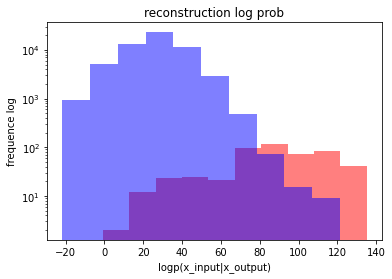

In [22]:
plt.hist(-x_log_prob[label==1],label="fraud",color="red",alpha = 0.5, log=True)
plt.hist(-x_log_prob[label==0],label="normal",color="blue",alpha=0.5, log=True)
plt.title("reconstruction log prob")
plt.ylabel("frequence log")
plt.xlabel("logp(x_input|x_output)")
plt.show()

In [23]:
fpr, tpr, threshold = roc_curve(label,-x_log_prob)
auc = roc_auc_score(label,-x_log_prob)

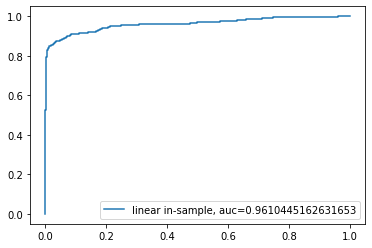

In [24]:
plt.plot(fpr,tpr,label=f"linear in-sample, auc={auc}")
plt.legend(loc="best")
plt.show()

### Choose a threshold that gives a good overall class1 recall 

In [25]:
results = pd.DataFrame({"label":label,"neg_log_prob":-x_log_prob})

In [53]:
results["pred_class"]=results.neg_log_prob.apply(lambda x: 1 if x>75.5 else 0)

In [54]:
confusion_matrix(results.label,results.pred_class)

array([[56729,   129],
       [  135,   357]])

In [55]:
print(classification_report(results.label, results.pred_class))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56858
           1       0.73      0.73      0.73       492

    accuracy                           1.00     57350
   macro avg       0.87      0.86      0.86     57350
weighted avg       1.00      1.00      1.00     57350

